<a href="https://colab.research.google.com/github/jakubgolab/Machine-Learning/blob/main/Breast_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<center>Supervised Machine Learning Project using Breast Cancer Dataset


---


Author: Jakub Gołąb, Poznan University of Technology



---



##Table of contents


1.   [General Info about Dataset](#1)
2.   [Exploratory Data Analysis EDA](#2)
3.   [Statistical Testing](#3)
4.   [Linear Regression](#4)
5.   [Classification - Model Selection](#5)
6.   [Model Details](#6)
7.   [Principal Components Analysis PCA](#7)



In [1]:
import warnings
warnings.filterwarnings('ignore') # Warnings are silenced

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
from sklearn.datasets import load_breast_cancer
raw_data = load_breast_cancer()
feature_names = list(raw_data.feature_names)
target_names = list(raw_data.target_names)
X = pd.DataFrame(raw_data.data, columns=feature_names)
y = pd.DataFrame(raw_data.target, columns=['diagnosis'])
df = X.copy()
df['diagnosis'] = y

###<a name=1></a>General Info about Dataset

In [4]:
print(raw_data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [5]:
print("Feature Names: ", feature_names)
print("Target Names: ", target_names)

Feature Names:  ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']
Target Names:  ['malignant', 'benign']


In [6]:
map = {
    0 : 'malignant',
    1 : 'benign'
}

###<a name=2></a>Exploratory Data Analysis EDA

Shape of the dataset

In [7]:
print(df.shape)

(569, 31)


Checking for the null values

In [8]:
assert df.isna().sum().sum() == 0

As shown, there are no missing values in our dataset.

Exploring data types

In [9]:
display(df.dtypes)

mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
worst radius               float64
worst texture              float64
worst perimeter            float64
worst area                 float64
worst smoothness           float64
worst compactness          float64
worst concavity            float64
worst concave points       float64
worst symmetry      

Every features are continuous (float type).
Target has binary type.

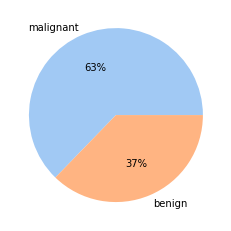

In [10]:
colors = sns.color_palette('pastel')[0:5]
plt.pie(df['diagnosis'].value_counts(), colors=colors, labels=target_names, autopct='%.0f%%')
plt.show()

The dataset consists of 30 features and 1 target ('malignant', 'benign'). Therefore, to get an insight into our data we shoud use t-SNE algorithm that reduces dimensionality for graphical exploratory.

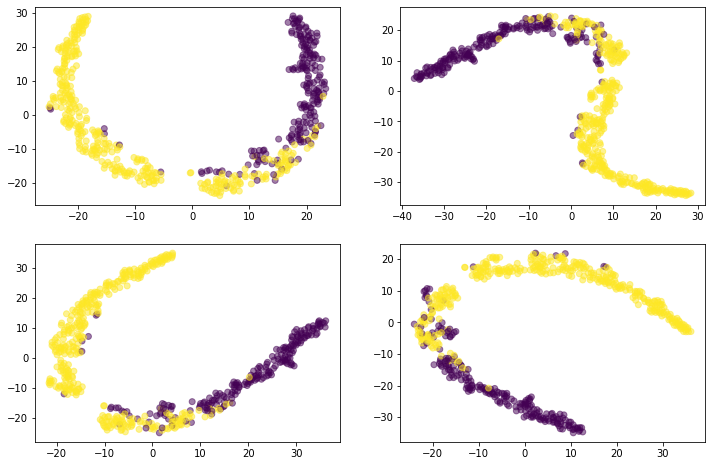

In [11]:
from sklearn.manifold import TSNE
learning_rate = [50, 100, 150, 200]
indices = [(0, 0), (0, 1), (1, 0), (1, 1)]
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for rate, i in zip(learning_rate, indices):
  model = TSNE(learning_rate=rate)
  transformed = model.fit_transform(X)
  Xs = transformed[:, 0]
  Ys = transformed[:, 1]
  axes[i[0], i[1]].scatter(Xs, Ys, c=y.values, alpha=0.5)
plt.show()

Exploring relationships among different features

Pairplot enables us to select a pair of variables that are interesting for the further analysis.

In [12]:
features = ['mean radius', 'mean texture', 'mean concave points', 
            'mean symmetry', 'worst radius', 'worst symmetry', 'diagnosis']
dataset = df[features]
dataset['diagnosis'] = dataset['diagnosis'].map(map)
dataset['diagnosis'] = dataset['diagnosis'].astype('category')

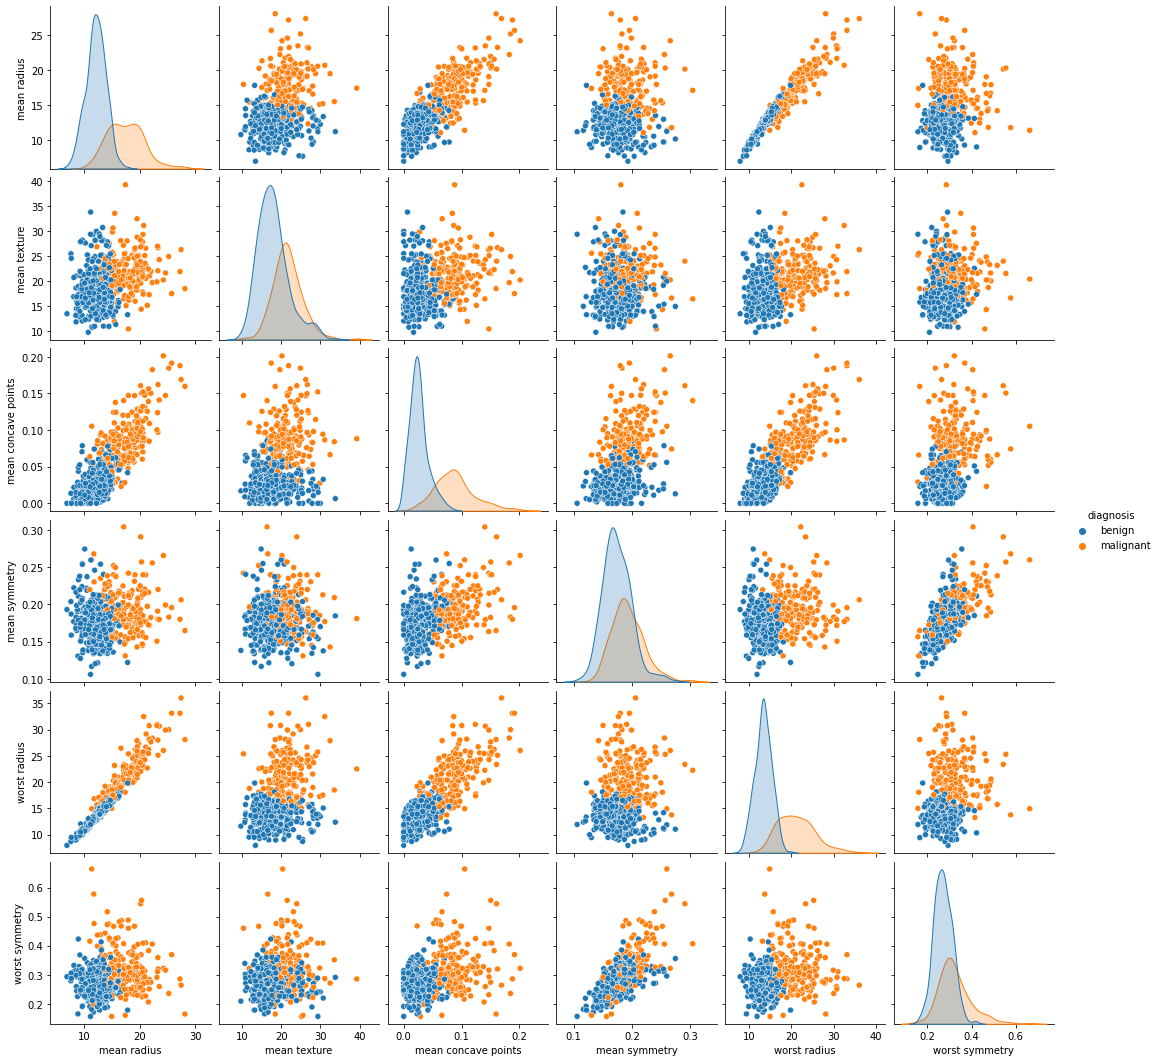

In [13]:
sns.set_style()
sns.pairplot(dataset, hue='diagnosis')
plt.show()

Judging from the plot, there are many subplots where points from different target class overlap each other.

Now let's see how these variables are correlated.

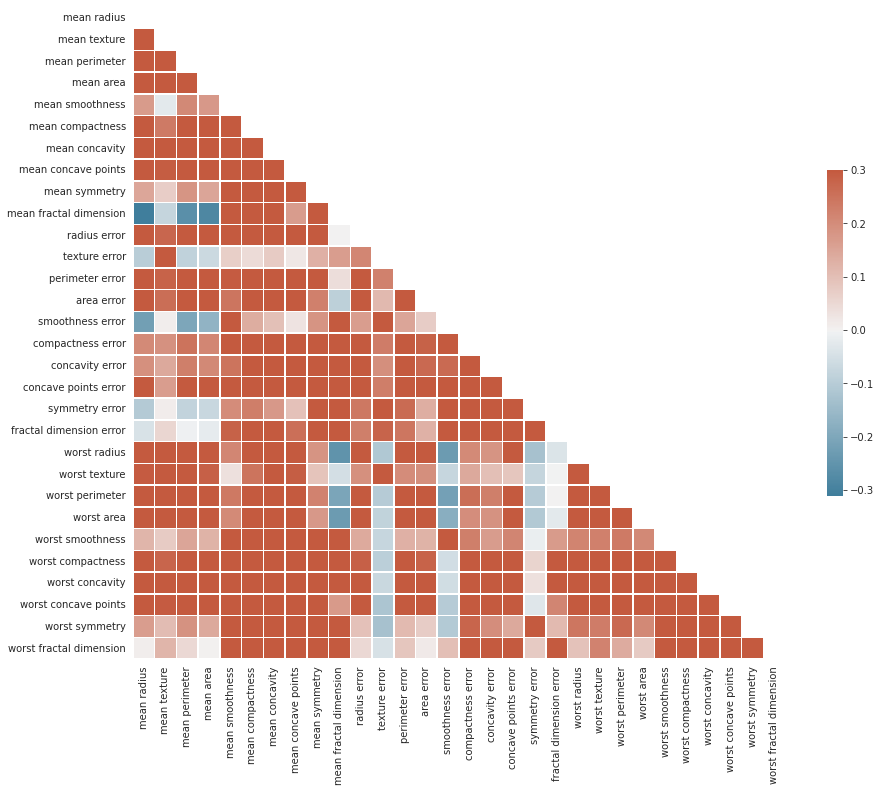

In [14]:
corr = X.corr()

sns.set_style('white')
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize = (15, 12))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, vmax=.3, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

####Conditional Selection

In [15]:
mean_radius = df['mean radius']
statistics = mean_radius.describe()
display(statistics)

count    569.000000
mean      14.127292
std        3.524049
min        6.981000
25%       11.700000
50%       13.370000
75%       15.780000
max       28.110000
Name: mean radius, dtype: float64

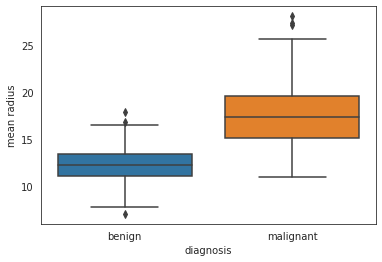

In [16]:
sns.set_style()
sns.boxplot(x=dataset['diagnosis'], y=dataset['mean radius'])
plt.show()

As we expected, breasts with malignant class tend to have large mean radius value than benign class.

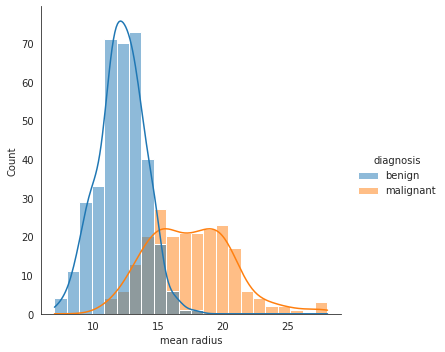

In [17]:
sns.displot(x='mean radius', kde=True, hue='diagnosis', data=dataset)
plt.show()

Are there some outliers?

In [18]:
IQR = statistics[6] - statistics[4]
lb = statistics[4] - (1.5 * IQR)
ub = statistics[6] + (1.5 * IQR)
condition = (mean_radius <= lb) | (mean_radius >= ub)

print(condition.value_counts())

False    555
True      14
Name: mean radius, dtype: int64


Let's explore how statistics will change without potential outliers.

In [19]:
mean_radius[~condition].describe()

count    555.000000
mean      13.865223
std        3.137897
min        6.981000
25%       11.665000
50%       13.240000
75%       15.495000
max       21.750000
Name: mean radius, dtype: float64

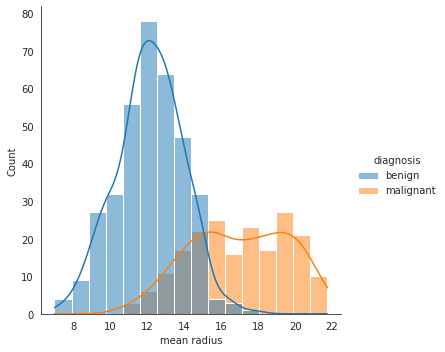

In [20]:
sns.displot(x='mean radius', kde=True, hue='diagnosis', data=dataset[~condition])
plt.show()

What is the maximum mean radius in our dataset?

In [21]:
max_mean_radius = df[df['mean radius'] == df['mean radius'].max()]
display(max_mean_radius)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
212,28.11,18.47,188.5,2499.0,0.1142,0.1516,0.3201,0.1595,0.1648,0.05525,...,18.47,188.5,2499.0,0.1142,0.1516,0.3201,0.1595,0.1648,0.05525,0


In [22]:
print("The maximum value of mean radius is: ", max_mean_radius['mean radius'].values[0])
print("From target class: ", max_mean_radius['diagnosis'].map(map).values[0])

The maximum value of mean radius is:  28.11
From target class:  malignant


###<a name=3></a>Statistical Testing (Mean Radius)

#### Z test

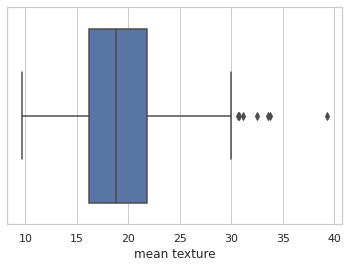

In [23]:
sns.set_theme(style="whitegrid")
sns.boxplot(x=dataset['mean texture'])
plt.show()

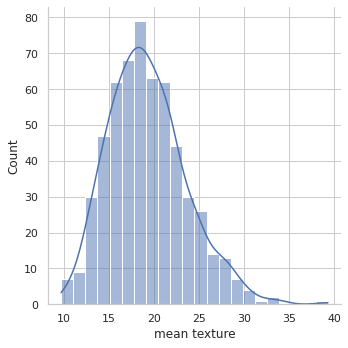

In [24]:
sns.set_theme(style="whitegrid")
sns.displot(x=dataset['mean texture'], kde=True)
plt.show()

As we can see this distribution follows normal distribution. Now we can perform a statistic test. We will use bootstrapping to generate our sample group.

In [25]:
# population parameter
mean = np.mean(dataset['mean texture'])
std = np.std(dataset['mean texture'], ddof=0)
print("Mean of the population: ", round(mean, 2))
print("Standard deviation of the population: ", round(std, 2))

Mean of the population:  19.29
Standard deviation of the population:  4.3


In [26]:
# generate a sample using bootstrapping technique
sample = dataset.sample(frac=1, replace=True, random_state=2)
sample = sample.sample(n=40, random_state=2)

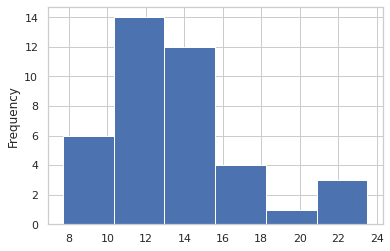

In [27]:
sns.set_theme(style="whitegrid")
sample['mean radius'].plot(kind='hist', bins=int(np.sqrt(40)))
plt.show()

Let's test if the mean value of 'mean radius' in our sample group is statistically comparable with the population

$$
H_0:μ_0=19.29\\
H_1:\mu_0\neq19.29
$$

$$
\alpha=0.05
$$

In [28]:
from scipy.stats import norm

# Z test
sample_mean = np.mean(sample['mean radius'])
std_error = np.std(sample['mean radius'], ddof=1)

Z_score = (sample_mean - mean) / std_error
p_value = 1 - norm.cdf(abs(Z_score), loc=0, scale=1)
print(p_value)

0.05876557483471134


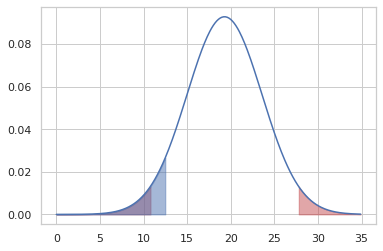

In [29]:
x_axis = np.arange(0, 35, 0.1)
y_axis = norm.pdf(x_axis, mean, std)
plt.fill_between(x_axis, y_axis, where=x_axis < norm.ppf(0.025, loc=mean, scale=std), alpha=0.5, color='r')
plt.fill_between(x_axis, y_axis, where=x_axis > norm.ppf(0.975, loc=mean, scale=std), alpha=0.5, color='r')
plt.fill_between(x_axis, y_axis, where=x_axis < norm.ppf(p_value, loc=mean, scale=std), alpha=0.5, color='b')
plt.plot(x_axis, y_axis)
plt.show()

We do not reject the null hypothesis.

### Test of Normality (Shapiro Wilk Test)

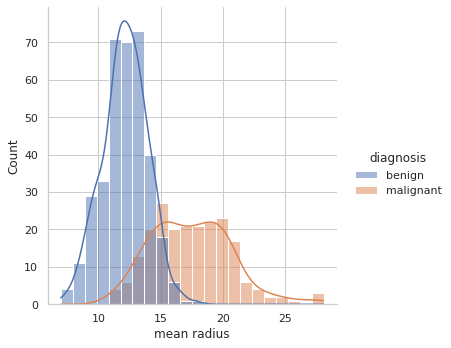

In [30]:
sns.displot(x='mean radius', kde=True, hue='diagnosis', data=dataset)
plt.show()

Judging by the histogram above, malignant class is more deviated than benign class. Let's compare standard deviation of these two groups.

In [31]:
dataset.groupby(by='diagnosis')['mean radius'].std(ddof=0)

diagnosis
benign       1.778016
malignant    3.196406
Name: mean radius, dtype: float64

Now we can check whether these distributions follow normal distribution.

In [32]:
from scipy.stats import shapiro

alpha = 0.05
malignant_class = dataset[dataset['diagnosis'] == 'malignant']['mean radius']
benign_class = dataset[dataset['diagnosis'] == 'benign']['mean radius']

shapiro_test_m = shapiro(malignant_class)
shapiro_test_b = shapiro(benign_class)

print(shapiro_test_m)
print("-------------")
print(shapiro_test_b)

ShapiroResult(statistic=0.9776597619056702, pvalue=0.0018945835763588548)
-------------
ShapiroResult(statistic=0.9966529011726379, pvalue=0.6679348349571228)


As a result, distribution of mean radius in benign class follows normal distribution whereas malignant class do not. Therefore, we cannot use normal distribution for probabilistics measurements in malignant class.

###<a name=4></a>Linear Regression

Let's see what is the relationship between 'mean area' and 'mean perimeter'

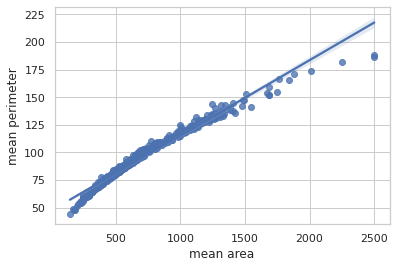

In [33]:
dataset = df[['mean area', 'mean perimeter', 'diagnosis']]
sns.set_style()
sns.regplot(x='mean area', y='mean perimeter', data = dataset)
plt.show()

As we can see, data that we use for linear regression needs to be transformed first.

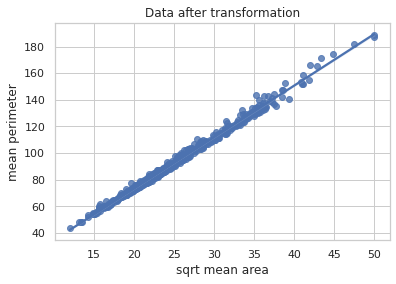

In [34]:
dataset['sqrt mean area'] = dataset['mean area'].apply(np.sqrt)

sns.set_style()
sns.regplot(x='sqrt mean area', y='mean perimeter', data = dataset).set_title("Data after transformation")
plt.show()

In [35]:
print("Pearson coefficient: ", np.corrcoef(dataset['sqrt mean area'], dataset['mean perimeter'])[0][1])
print("R^2: ", np.corrcoef(dataset['sqrt mean area'], dataset['mean perimeter'])[0][1]**2)

Pearson coefficient:  0.9969209931138514
R^2:  0.9938514665111078


In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


rmse = []

for i in range(1000):
  X_train, X_test, y_train, y_test = train_test_split(dataset['sqrt mean area'].values.reshape(-1, 1), 
                                                      dataset['mean perimeter'].values.reshape(-1, 1), test_size=0.25)
  scaler = StandardScaler()
  linreg = LinearRegression()
  pipe = make_pipeline(scaler, linreg)
  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_test)
  rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))

rmse = pd.DataFrame(data=rmse, columns=['RMSE'])
display(rmse.describe().T)

,count,mean,std,min,25%,50%,75%,max
RMSE,1000.0,1.915233,0.172862,1.305219,1.786528,1.904318,2.035285,2.497879


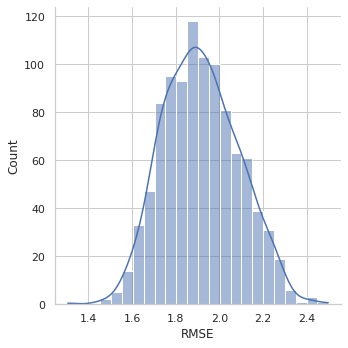

In [37]:
sns.set_style()
sns.displot(x='RMSE', data=rmse, kde=True)
plt.show()

In [38]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

scaler = StandardScaler()
linreg = LinearRegression()
loo = LeaveOneOut()
pipe = make_pipeline(scaler, linreg)
samples = dataset.sample(frac=1)
neg_mse = cross_val_score(pipe, dataset['sqrt mean area'].values.reshape(-1, 1), 
                          dataset['mean perimeter'].values.reshape(-1, 1), cv=loo, 
                          scoring='neg_mean_squared_error', n_jobs=-1)

rmse_loo = pd.DataFrame(data=np.sqrt(-neg_mse), columns=['RMSE'])


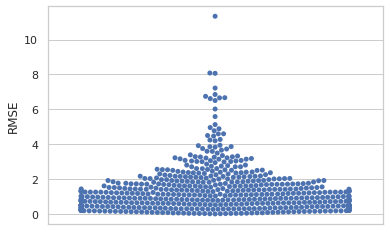

In [39]:
sns.set_style()
sns.swarmplot(y='RMSE', data=rmse_loo)
plt.show()

###Residual plot

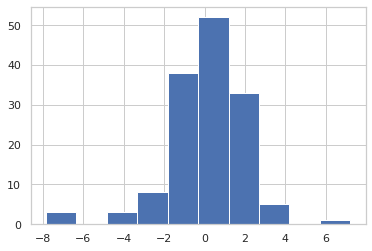

In [40]:
regression = pd.DataFrame(data = np.concatenate((y_test, y_pred), axis=1), 
                          columns = ['Y_ Test', 'Y_ Pred'])
regression['Error'] = regression['Y_ Pred'] - regression['Y_ Test']
regression['Error'].hist()
plt.show()

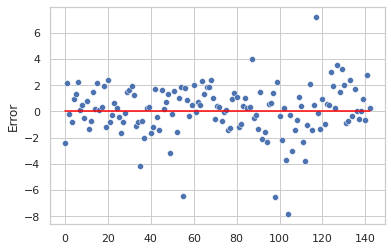

In [41]:
sns.scatterplot(x=np.arange(0, len(regression['Error'])), y=regression['Error'])
sns.lineplot(x=[0, len(regression['Error'])-1], y=[0, 0], color='red')
plt.show()

We can assume that our residuals follow normal distribution and their scatter plot has a 'belt' shape. Therefore, assumptions concern linear regression are fulfiled.

###<a name=5></a>Classification - Model Selection

Now let's consider a classification problem. In our dataset we have two target classes: benign and malignant. Our task is to find the best classifier (with the best hyperparamethers) to work well in real-world input.

,accuracy
most_frequent,0.629371
stratified,0.573427
uniform,0.454545
prior,0.629371


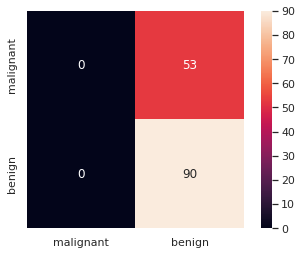

In [42]:
# Basic Dummy Classifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
dataset = df.copy()
X = raw_data.data
y = raw_data.target
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1, 1), random_state=42, stratify=y)
strategies = ['most_frequent', 'stratified', 'uniform', 'prior']
accuracy = {}

for strategy in strategies:
  dummy_classifier = DummyClassifier(strategy=strategy)
  y_pred = dummy_classifier.fit(X_train, y_train).predict(X_test)
  accuracy[strategy] = accuracy_score(y_test, y_pred)

accuracy = pd.DataFrame(accuracy.values(), index=accuracy.keys(), columns=['accuracy'])
display(accuracy)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, square=True, 
            xticklabels=raw_data.target_names, yticklabels=raw_data.target_names)
plt.show()

Naive Gaussian Classifier accuracy score:  0.937


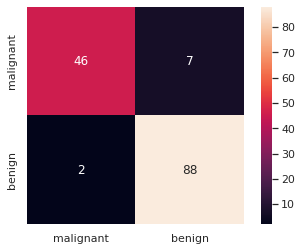

In [43]:
# Naive Gaussian Classifier
from sklearn.naive_bayes import GaussianNB
y_pred = GaussianNB().fit(X_train, y_train).predict(X_test)
print("Naive Gaussian Classifier accuracy score: ", np.round(accuracy_score(y_test, y_pred), 3))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, square=True, 
            xticklabels=raw_data.target_names, yticklabels=raw_data.target_names)
plt.show()

The best params:  {'n_neighbors': 5}
K-Neighbors Classifier accuracy score:  0.93


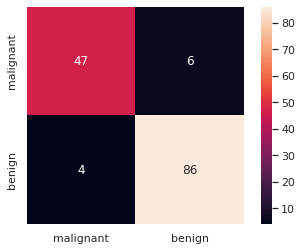

In [44]:
# K Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, GridSearchCV

kf = KFold(n_splits=10, shuffle=True, random_state=42) # splitting our data
parameters = {'n_neighbors' : np.arange(1, 26)} # finding the best number of neighbors
kn = KNeighborsClassifier()
model = GridSearchCV(estimator=kn, param_grid = parameters, scoring='accuracy', cv=kf)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("The best params: ", model.best_params_)
print("K-Neighbors Classifier accuracy score: ", np.round(accuracy_score(y_test, y_pred), 3))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, square=True, 
            xticklabels=raw_data.target_names, yticklabels=raw_data.target_names)
plt.show()

Let's plot the complexity of our model

In [45]:
train_accuracies = []
test_accuracies = []
n_neigh = np.arange(1, 26)

for n in n_neigh:
  kn = KNeighborsClassifier(n_neighbors = n)
  kn.fit(X_train, y_train)
  train_pred = kn.predict(X_train)
  test_pred = kn.predict(X_test)
  train_accuracies.append(kn.score(X_train, y_train))
  test_accuracies.append(kn.score(X_test, y_test))

train_accuracies = np.array(train_accuracies)
test_accuracies = np.array(test_accuracies)

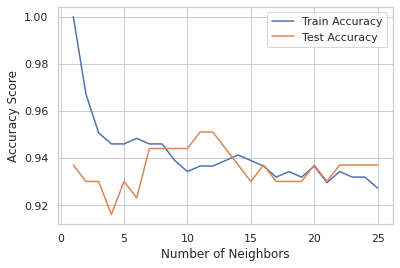

In [46]:
plt.plot(n_neigh, train_accuracies, label='Train Accuracy')
plt.plot(n_neigh, test_accuracies, label='Test Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy Score')
plt.show()

Decision Tree Classifier accuracy score:  0.965


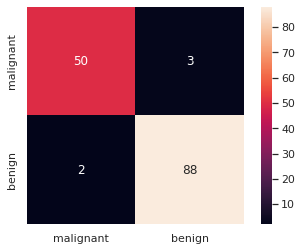

In [47]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=42)

parameters = {
    'max_depth' : np.arange(1, 11),
    'min_samples_leaf' : [0.02, 0.04, 0.06, 0.08, 0.1],
    'max_features' : [0.2, 0.4, 0.6, 0.8, 0.1],
    'criterion' : ['gini', 'entropy']
}

model = GridSearchCV(estimator = dtc, param_grid = parameters, cv=10, scoring='accuracy')
model.fit(X_train, y_train)

best_model = model.best_estimator_
y_pred = best_model.predict(X_test)
print("Decision Tree Classifier accuracy score: ", np.round(accuracy_score(y_test, y_pred), 3))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, square=True, 
            xticklabels=raw_data.target_names, yticklabels=raw_data.target_names)
plt.show()

In [48]:
parameters = model.best_params_
display(parameters)

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 0.1,
 'min_samples_leaf': 0.02}

As we can see, the best model for our purposes will be Decision Tree Classifier. Nevertheless, we cannot rely on accuracy score only. Let's take a closer look on classification report. There will be some other values that we need to take into account.

In [49]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        53
           1       0.97      0.98      0.97        90

    accuracy                           0.97       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.97      0.96       143



TPR:  [0.         0.85555556 0.88888889 0.94444444 0.96666667 0.97777778
 0.97777778 1.        ]
FPR:  [0.         0.03773585 0.03773585 0.03773585 0.03773585 0.05660377
 0.09433962 1.        ]
AUC:  0.9669811320754718


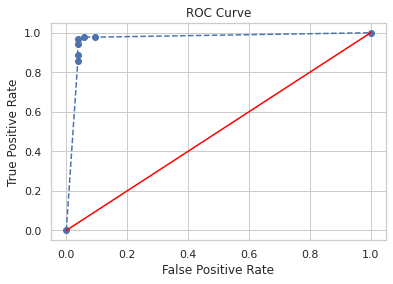

In [50]:
from sklearn.metrics import roc_curve, auc

y_proba = best_model.predict_proba(X_test)[:, 1]
false_positive_rate, true_positive_rate, treshold = roc_curve(y_test, y_proba)
auc = auc(false_positive_rate, true_positive_rate)

print("TPR: ", true_positive_rate)
print("FPR: ", false_positive_rate)
print("AUC: ", auc)

fig, ax = plt.subplots()
ax.plot(false_positive_rate, true_positive_rate, 'o--')
ax.plot([0, 1], [0, 1], c='red')
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve")
plt.show()

As mentioned earlier, in this case we should bear in mind that accuracy score is not sufficient. In many medical examples, like this, we should put emphasis on ballance between True Positives and False Positives.
For instance, in medical examples false negative error can be really precarious (a patient can be diagnosed negatively on a particular disease whereas they can be infected).
As a solution we can take a look on ROC curve that give us insight in possible thresholds that can reduce False Negatives.

###<a name=6></a>Model Details

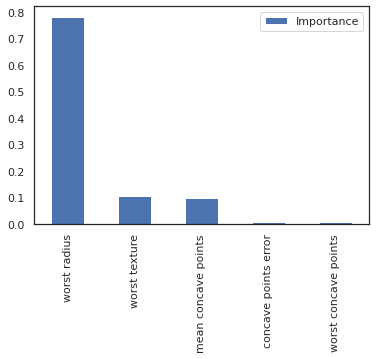

In [51]:
feat_imp = pd.DataFrame(data=best_model.feature_importances_, 
                        index=feature_names, columns=['Importance'])
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

sns.set_style('white')
feat_imp.head().plot(kind='bar')
plt.show()

Now we can see chosen parameters of our tree

In [52]:
print(best_model.get_params)

<bound method BaseEstimator.get_params of DecisionTreeClassifier(max_depth=5, max_features=0.1, min_samples_leaf=0.02,
                       random_state=42)>


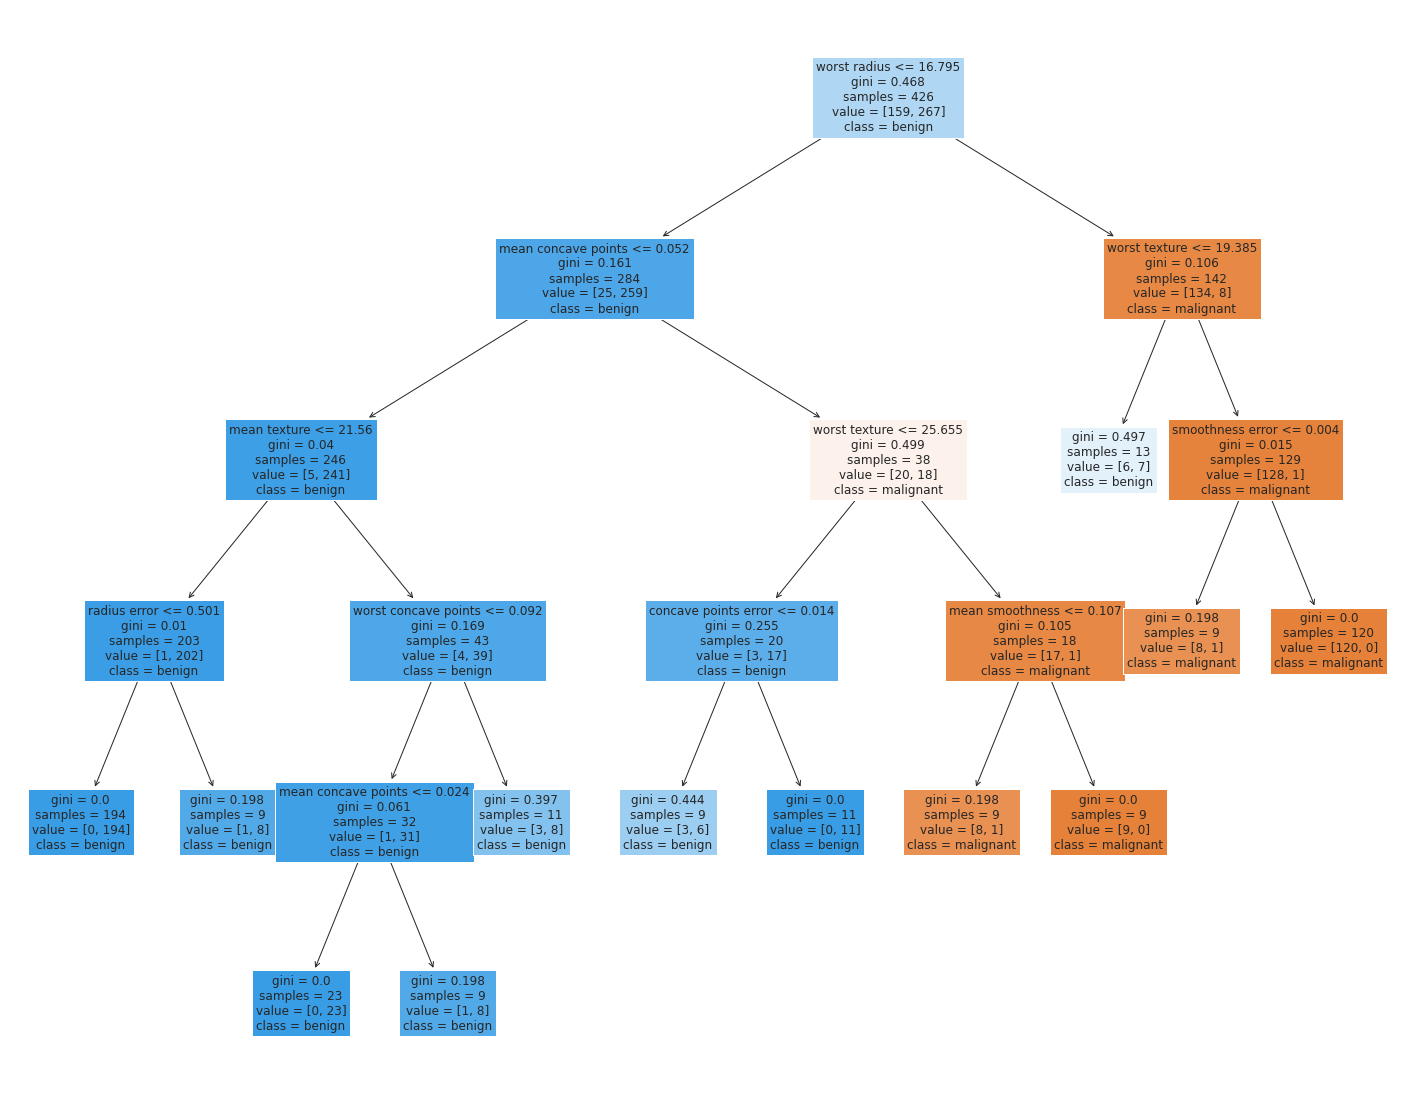

In [53]:
from sklearn.tree import plot_tree

fig = plt.subplots(figsize=(25, 20))
_ = plot_tree(best_model, feature_names = feature_names, 
              class_names = map, filled = True, fontsize = 12)
plt.show()

###<a name=7></a>Principal Components Analysis PCA

In this part we are going to use PCA for reduction dimensionality. First of all, let's check which features are classified to be usefull.

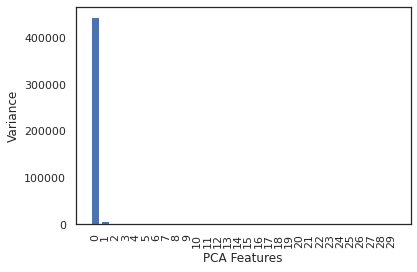

In [54]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.xticks(rotation=90)
plt.xlabel('PCA Features')
plt.ylabel('Variance')
plt.show()

Let's assume that the first three features (0, 1, 2) are informatitive.

In [55]:
pca = PCA(n_components=3)
transformed_X = pca.fit_transform(X)

In [56]:
columns = ['feature_1', 'feature_2', 'feature_3']
df = pd.DataFrame(transformed_X, columns=columns)
df['diagnosis'] = y

display(df.head())

,feature_1,feature_2,feature_3,diagnosis
0,1160.142574,-293.917544,48.578398,0
1,1269.122443,15.630182,-35.394534,0
2,995.793889,39.156743,-1.709753,0
3,-407.180803,-67.380320,8.672848,0
4,930.341180,189.340742,1.374801,0


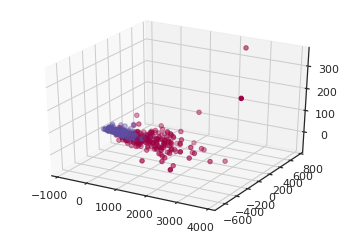

In [57]:
sns.set_style('white')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df['feature_1'], df['feature_2'], df['feature_3'], 
           c=df['diagnosis'].values, cmap='Spectral')
plt.show()

When we have lots of data. We can perform PCA as it reduces the time of training the model.